In [1]:
import sys
import collections
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import mode
from scipy.spatial.distance import squareform

In [36]:
import sys
print(f"Python version: {sys.version}")

Python version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


In [8]:
plt.style.use('bmh')
%matplotlib inline

try:
    from IPython.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays

    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN

    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function

    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second

    """

    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step

    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels

        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer

        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """

        self.x = x
        self.l = l

    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared

d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function

        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxsize * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window
        return cost[-1, -1]

    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure

        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]

        y : array of shape [n_samples, n_timepoints]

        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """

        # Compute the distance matrix
        dm_count = 0

        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)

            p = ProgressBar(shape(dm)[0])

            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                      y[j, ::self.subsample_step])

                    dm_count += 1
                    p.animate(dm_count)

            # Convert to squareform
            dm = squareform(dm)
            return dm

        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0]))
            dm_size = x_s[0]*y_s[0]

            p = ProgressBar(dm_size)

            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
                    p.animate(dm_count)

            return dm

    def predict(self, x):
        """Predict the class labels or probability estimates for
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified

Returns
        -------
          2 arrays representing:
              (1) the predicted class labels
              (2) the knn label count probability
        """

        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]

        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()

class ProgressBar:
    """This progress bar was taken from PYMC
    """
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        print ('\r', self)
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])



    def __str__(self):
        return str(self.prog_bar)

In [10]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):


    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [19]:
# Load the file from Drive
Opto = pd.read_excel('/content/drive/MyDrive/Sniff_Time_Series/SniffingData.xlsx', sheet_name='Opto')
Odor = pd.read_excel('/content/drive/MyDrive/Sniff_Time_Series/SniffingData.xlsx', sheet_name='Odor')
Buzz = pd.read_excel('/content/drive/MyDrive/Sniff_Time_Series/SniffingData.xlsx', sheet_name='Buzz')
Spontaneous = pd.read_excel('/content/drive/MyDrive/Sniff_Time_Series/SniffingData.xlsx', sheet_name='Spontaneous')

In [20]:
# Take values from the file
OptoSniffFreq = np.asfarray(Opto['26 InstFreq'].values)
OdorSniffFreq = np.asfarray(Odor['18 InstFreq'].values)
BuzzSniffFreq = np.asfarray(Buzz['18 InstFreq'].values)
SponSniffFreq = np.asfarray(Spontaneous['18 InstFreq'].values)

In [25]:
# Reshape data
OptoSniff = OptoSniffFreq.reshape(63, 100)
OdorSniff = OdorSniffFreq.reshape(65, 100)
BuzzSniff = BuzzSniffFreq.reshape(63, 100)
SpontaneousSniff = SponSniffFreq.reshape(70, 100)

In [6]:
# Check the shapes of each array
print(OptoSniff.shape, OdorSniff.shape, BuzzSniff.shape, SpontaneousSniff.shape)

(63, 100) (65, 100) (63, 100) (70, 100)


In [39]:
# Define the number of samples to be selected dynamically (20, 40, 60)
np.random.seed(42)

num_samples = 20

selected_indices1 = np.random.choice(OptoSniff.shape[0], num_samples, replace=False)
selected_indices2 = np.random.choice(OdorSniff.shape[0], num_samples, replace=False)
selected_indices3 = np.random.choice(BuzzSniff.shape[0], num_samples, replace=False)
selected_indices4 = np.random.choice(SpontaneousSniff.shape[0], num_samples, replace=False)

OptoSniff_20 = OptoSniff[selected_indices1, :]
OdorSniff_20 = OdorSniff[selected_indices2, :]
BuzzSniff_20 = BuzzSniff[selected_indices3, :]
SpontaneousSniff_20 = SpontaneousSniff[selected_indices4, :]

In [28]:
# Train Test Split and Normalization (20, 40, 60)

X = np.concatenate((OptoSniff_20, OdorSniff_20, BuzzSniff_20, SpontaneousSniff_20), axis=0)
Y = np.ones(num_samples*4)
Y = Y.astype('int64')
Y[num_samples:num_samples*2] = 2
Y[num_samples*2:num_samples*3] = 3
Y[num_samples*3:num_samples*4] = 4

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=23, stratify=Y)

from sklearn.preprocessing import MinMaxScaler
mmsc = MinMaxScaler()
X_train_norm = mmsc.fit_transform(X_train)
X_test_norm = mmsc.transform(X_test).clip(0,1)

In [41]:
# Train Test Split and Normalization for all samples (63_65_63_70)

X = np.concatenate((OptoSniff, OdorSniff, BuzzSniff, SpontaneousSniff), axis=0)
labels1 = np.zeros(OptoSniff.shape[0])
labels2 = np.ones(OdorSniff.shape[0])
labels3 = np.full(BuzzSniff.shape[0], 2)
labels4 = np.full(SpontaneousSniff.shape[0], 3)
Y = np.concatenate((labels1, labels2, labels3, labels4))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=23, stratify=Y)

from sklearn.preprocessing import MinMaxScaler
mmsc = MinMaxScaler()
X_train_norm = mmsc.fit_transform(X_train)
X_test_norm = mmsc.transform(X_test).clip(0,1)

In [29]:
# Classificaiton using KnnDtw
m = KnnDtw(n_neighbors=3, max_warping_window=7)
m.fit(X_train_norm, y_train)
label, proba = m.predict(X_test_norm)

 [                  0%                  ]
 [                  0%                  ]  2 of 1024 complete
 [                  0%                  ]  3 of 1024 complete
 [                  0%                  ]  4 of 1024 complete
 [                  0%                  ]  5 of 1024 complete
 [                  1%                  ]  6 of 1024 complete
 [                  1%                  ]  7 of 1024 complete
 [                  1%                  ]  8 of 1024 complete
 [                  1%                  ]  9 of 1024 complete
 [                  1%                  ]  10 of 1024 complete
 [                  1%                  ]  11 of 1024 complete
 [                  1%                  ]  12 of 1024 complete
 [                  1%                  ]  13 of 1024 complete
 [                  1%                  ]  14 of 1024 complete
 [                  1%                  ]  15 of 1024 complete
 [*                 2%                  ]  16 of 1024 complete
 [*                 2

               precision    recall  f1-score   support

OptoSniffFreq       1.00      0.75      0.86         4
OdorSniffFreq       0.38      0.75      0.50         4
BuzzSniffFreq       1.00      0.50      0.67         4
SponSniffFreq       0.33      0.25      0.29         4

     accuracy                           0.56        16
    macro avg       0.68      0.56      0.58        16
 weighted avg       0.68      0.56      0.58        16



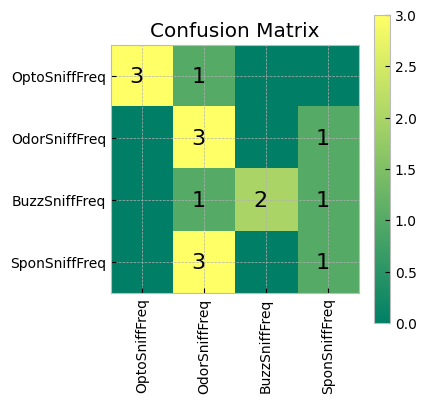

In [31]:
# Results based on number of samples (20, 40, 60 and for all samples (63_65_63_70))

labels = {1:'OptoSniffFreq', 2:'OdorSniffFreq', 3:'BuzzSniffFreq',
          4:'SponSniffFreq'}

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, label,
                            target_names=[l for l in labels.values()]))

conf_mat = confusion_matrix(y_test, label)

fig = plt.figure(figsize=(4,4))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)

cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(4), [l for l in labels.values()], rotation=90)
_ = plt.yticks(range(4), [l for l in labels.values()])

In [32]:
# Apply SMOTE to balance the combined dataset (70 samples for each class)
!pip install imbalanced-learn

import numpy as np
from imblearn.over_sampling import SMOTE

np.random.seed(42)

labels1 = np.zeros(OptoSniff.shape[0])
labels2 = np.ones(OdorSniff.shape[0])
labels3 = np.full(BuzzSniff.shape[0], 2)
labels4 = np.full(SpontaneousSniff.shape[0], 3)

X = np.vstack((OptoSniff, OdorSniff, BuzzSniff, SpontaneousSniff))
y = np.concatenate((labels1, labels2, labels3, labels4))

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

print("Balanced X shape:", X_balanced.shape)
print("Balanced y shape:", y_balanced.shape)

unique, counts = np.unique(y_balanced, return_counts=True)
print("Class distribution after SMOTE:", dict(zip(unique, counts)))

Balanced X shape: (280, 100)
Balanced y shape: (280,)
Class distribution after SMOTE: {0.0: 70, 1.0: 70, 2.0: 70, 3.0: 70}


In [33]:
# Train Test Split and Normalization after SMOTE

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=23, stratify=y_balanced)

from sklearn.preprocessing import MinMaxScaler
mmsc = MinMaxScaler()
X_train_norm = mmsc.fit_transform(X_train)
X_test_norm = mmsc.transform(X_test).clip(0,1)

In [34]:
# Classificaiton using KnnDtw
m = KnnDtw(n_neighbors=3, max_warping_window=7)
m.fit(X_train_norm, y_train)
label, proba = m.predict(X_test_norm)

Streaming output truncated to the last 5000 lines.
 [*****************60%***               ]  7545 of 12544 complete
 [*****************60%***               ]  7546 of 12544 complete
 [*****************60%***               ]  7547 of 12544 complete
 [*****************60%***               ]  7548 of 12544 complete
 [*****************60%***               ]  7549 of 12544 complete
 [*****************60%***               ]  7550 of 12544 complete
 [*****************60%***               ]  7551 of 12544 complete
 [*****************60%***               ]  7552 of 12544 complete
 [*****************60%***               ]  7553 of 12544 complete
 [*****************60%***               ]  7554 of 12544 complete
 [*****************60%***               ]  7555 of 12544 complete
 [*****************60%***               ]  7556 of 12544 complete
 [*****************60%***               ]  7557 of 12544 complete
 [*****************60%***               ]  7558 of 12544 complete
 [*****************60%***

               precision    recall  f1-score   support

OptoSniffFreq       1.00      1.00      1.00        14
OdorSniffFreq       0.50      0.86      0.63        14
BuzzSniffFreq       0.67      0.57      0.62        14
SponSniffFreq       0.67      0.29      0.40        14

     accuracy                           0.68        56
    macro avg       0.71      0.68      0.66        56
 weighted avg       0.71      0.68      0.66        56



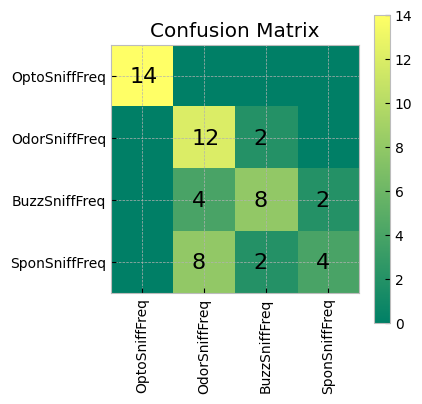

In [35]:
# Results based on number of samples (70 samples for each class after SMOTE)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, label,
                            target_names=[l for l in labels.values()]))

conf_mat = confusion_matrix(y_test, label)

fig = plt.figure(figsize=(4,4))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)

cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(4), [l for l in labels.values()], rotation=90)
_ = plt.yticks(range(4), [l for l in labels.values()])

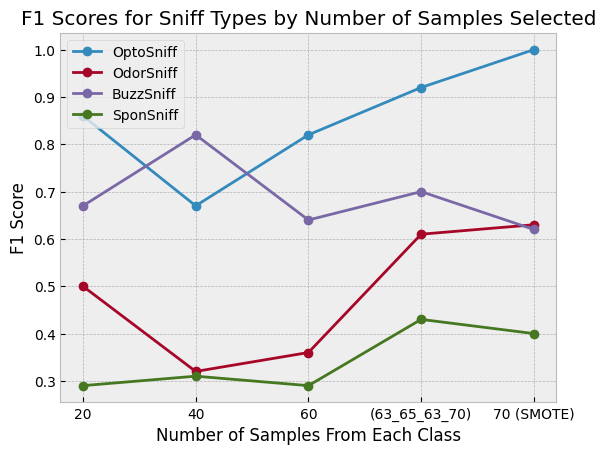

In [31]:
# Comparing F1 score for each result

OptoSniff_F1_score = np.array([0.86, 0.67, 0.82, 0.92, 1])
OdorSniff_F1_score = np.array([0.50, 0.32, 0.36, 0.61, 0.63])
BuzzSniff_F1_score = np.array([0.67, 0.82, 0.64, 0.70, 0.62])
SponSniff_F1_score = np.array([0.29, 0.31, 0.29, 0.43, 0.40])

x = np.arange(len(OptoSniff_F1_score))

plt.plot(x, OptoSniff_F1_score, marker='o', label='OptoSniff')
plt.plot(x, OdorSniff_F1_score, marker='o', label='OdorSniff')
plt.plot(x, BuzzSniff_F1_score, marker='o', label='BuzzSniff')
plt.plot(x, SponSniff_F1_score, marker='o', label='SponSniff')

tick_labels = ['20', '40', '60', '(63_65_63_70)', '70 (SMOTE)']
plt.xticks(x, tick_labels)

plt.xlabel('Number of Samples From Each Class')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Sniff Types by Number of Samples Selected')
plt.legend(loc='upper left')

plt.grid(True)
plt.show()